# Exercise 3 - R:  Multi-class Classification and Neural Networks

## *Part One*: Multi-class Classification with Logistic Regression

Recognizing handwritten digits.  Though the source is not explicitly mentioned, it is just like the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database).

Each value of $X$ will be a 20x20 grid of values representing the grayscale intensity at that location "unrolled" into a 400-dimensional vector.  Here is an example for the first number in our data, $X^{(1)}$:

$\hspace{1cm} X^{(1)} = \begin{bmatrix}x_{(1, 1)}^{(1)},\ x_{(1, 2)}^{(1)},\ \dots\ x_{(1, 20)}^{(1)} \\
                                    x_{(2, 1)}^{(1)},\ x_{(2, 2)}^{(1)},\ \dots\ x_{(2, 20)}^{(1)} \\
                                    \vdots \\ 
                                    x_{(20, 1)}^{(1)},\ x_{(20, 2)}^{(1)},\ \dots\ x_{(20, 20)}^{(1)} \\ 
                    \end{bmatrix}
\rightarrow \begin{bmatrix} x_1^{(1)},\ x_2^{(1)},\ \dots\ x_{400}^{(1)} \end{bmatrix}
\rightarrow (x^{(1)})^T$

Here is our collection of all of the numbers for $X$:

$\hspace{1cm} X = \begin{bmatrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(400)})^T \end{bmatrix}$

---

Beginning with package imports, data loading, and initial visualization

In [2]:
rm(list=ls())  # Clearing all environment variables

suppressPackageStartupMessages({
  library(R.matlab)  # Reads MATLAB/Octave  matrices
  library(utils)  # Used for a status bar in lengthy for loops
  library(ggplot2)
  library(tidyr)
  library(dplyr)
})

theme_update(plot.title = element_text(hjust = 0.5))  # Centers ggplot2 titles

In [3]:
# Loading in the data from the .mat files
data <- readMat('ex3/ex3data1.mat')

# Assigning X/y and removing data from environment
X <- data$X
y <- data$y
rm(data)  # Clearing data from environment

# Replacing where 0 is marked as 10 in y
y <- ifelse(y == 10, 0, y)

# Adding the intercept term for X
X <- cbind(1, X)

# An array of 0s for starting values of theta to be used to test functions
initialTheta <- numeric(dim(X)[2])

print(dim(X))

[1] 5000  401


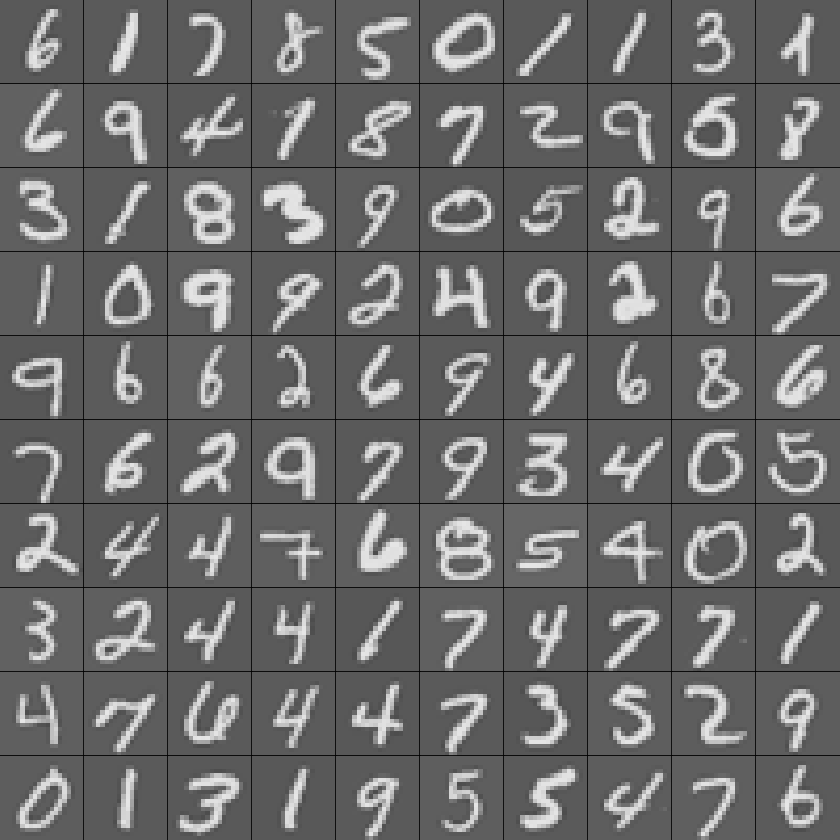

In [4]:
# Randomly selecting 100 digits to plot
rowsToPlot <- X[sample(nrow(X),size=100,replace=FALSE),]

row_to_matrix <- function(row) {
  # Formats a row from the matrix X into a matrix suitable for plotting with image()
  digit <- matrix(row, nrow=20, ncol=20)  # Puts row into a 20x20 matrix
  digit <- t(apply(digit, 2, rev))  # Rotates matrix into correct position for image()
  return(digit)
}

plot_digits <- function(digits) {
  # Plots a grid of the supplied digits
  
  # Calculating parameters for the plot
  m <- dim(digits)[1]  # Number of digits to plot
  columns <- floor(sqrt(m))  # Number of columns
  rows <- ceiling(sqrt(m))  # Number of rows

  # Parameters for the overall plot
  par(mfrow=c(rows, columns),  # Rows, columns
      mar=c(0.0, 0.0, 0.0, 0.0))  # Margins between plots

  # Looping through the digits and plotting them
  for (i in 1:m) {
  image(row_to_matrix(digits[i, -1]),  # Formats digit and removes intercept term
        col=grey.colors(255),  # Colors to gray scale
        xaxt='n', yaxt='n')  # Remoxes axis labels and tick marks
  }
}

plot_digits(rowsToPlot)

In [5]:
# One hot encoding 7 for testing functions 
y7 <- ifelse(y == 7, 1, 0)


logistic_hypothesis <- function(theta, X) {
  # Calculates the hypothesis for X given values of
  # theta for logistic regression
  X <- as.matrix(X)
  theta <- as.matrix(theta)
  
  h <- X %*% theta  # Linear prediction
  h <- 1/(1+exp(-h))  # Sigmoid function
  return(h)
}

In [7]:
regularized_cost <- function(theta, X, y, C=0.0) {
  # Computes cost for logistic regression
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
  error <- sum(-y*log(h)-(1-y)*log(1-h))
  
  # Calculating the regularization parameter
  # Avoiding the regularization parameter for the first theta
  regularizedTheta <- theta[-1] ** 2
  regularization <- (C/(2*m)) * sum(regularizedTheta)
  
  J <- (1/m)*error + regularization
  return(J)
}

regularized_cost(initialTheta, X, y7)

[1] 0.6931472

In [8]:
regularized_gradient <- function(theta, X, y, C=0.0) {
  # Computes the gradient for logistic regression
  X <- as.matrix(X)
  y <- as.matrix(y)
  theta <- as.matrix(theta)
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
    
  # Calculating the regularization parameter for all thetas but the intercept
  regParam <- (C/m) * theta[-1]
    
  gradient <- (1/m) * (t(X) %*% (h-y))
  gradient[-1] <- gradient[-1] + regParam
  return(gradient)
}

regularized_gradient(initialTheta, X, y7)[1:5]

[1]  4.000000e-01  0.000000e+00  0.000000e+00  7.745302e-08 -5.300466e-07

In [10]:
optimize_theta <- function(X, y, C=0.0) {
  # Find values of theta that minimize the cost function
  # Takes roughly four minutes per digit
  optimalTheta <- optim(
        # Specifying function parameters
        par=initialTheta,  # Initial guess
        fn=regularized_cost,  # Function to minimize
        X=X,
        y=y,
        C=C,
        method="BFGS",  #  Optimization function to use
        control=list(maxit = 40)  # Maximum number of iterations
      )$par  # Specifying that we only want the obtained thetas
  return(optimalTheta)
}

# Beginning timing
startTime <- proc.time()  

optimize_theta(X, y7)[1:5]

endTime <- proc.time()  
endTime - startTime

[1] -1.143990e+00  0.000000e+00  0.000000e+00 -1.035547e-05  7.960791e-05

   user  system elapsed 
 222.39    0.19  224.83 